# KEM

## Preliminaries

Import required packages

In [1]:
from __future__ import annotations
import os
import matplotlib.pyplot as plt
import torch
from pytomography.io.SPECT import simind
from pytomography.projectors import SPECTSystemMatrix
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM, KEM
from pytomography.transforms import KEMTransform

Modify the following path to the directory where you saved the tutorial data:

In [2]:
path = '/disk1/pytomography_tutorial_data/simind_tutorial/'

The first cell of code is borrowed from the `SPECT: Reconstructing SIMIND Data` tutorial in the multiple regions case. For a more comprehensive description about the code below, please see that tutorial.

In [3]:
organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
activities = [2500, 450, 7, 7, 100, 100, 20, 90] # MBq
headerfiles = [os.path.join(path, 'multi_projections', organ, 'photopeak.h00') for organ in organs]
headerfiles_lower = [os.path.join(path, 'multi_projections', organ, 'lowerscatter.h00') for organ in organs]
headerfiles_upper = [os.path.join(path, 'multi_projections', organ, 'upperscatter.h00') for organ in organs]
object_meta, proj_meta = simind.get_metadata(headerfiles[0]) #assumes the same for all
photopeak = simind.combine_projection_data(headerfiles, activities)
scatter = simind.combine_scatter_data_TEW(headerfiles, headerfiles_lower, headerfiles_upper, activities)
dT = 5 #s
photopeak = torch.poisson(photopeak * dT)
scatter = torch.poisson(scatter * dT)
attenuation_map = simind.get_attenuation_map(os.path.join(path, 'multi_projections', 'mu208.hct'))
att_transform = SPECTAttenuationTransform(attenuation_map)
psf_meta = simind.get_psfmeta_from_header(headerfiles[0])
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta,
    n_parallel=2)

For reference, let's reconstruct an image using OSEM:

In [4]:
reconstruction_algorithm = OSEM(
    projections = photopeak,
    system_matrix = system_matrix,
    scatter = scatter)
reconstructed_object = reconstruction_algorithm(n_iters=10, n_subsets=8)

The kernelized expectation maximum algorithm can be written as

$$\hat{\alpha}^{n,m+1} = \left[\frac{1}{K^T H_m^T 1} K^T H_m^T \left(\frac{g_m}{H_m K \hat{\alpha}^{n,m}+s}\right)\right] \hat{\alpha}^{n,m}$$

where the reconstructed object estimate is given by $\hat{f}^{n,m+1} = K \hat{\alpha}^{n,m+1}$. This is nearly identical to OSEM, but a matrix $K$ is now involved. Thus we need to do two things in PyTomography

1. Obtain the matrix $K$
2. Using the matrix $K$ in the `KEM` reconstruction algorithm.

The matrix $K$ is a square matrix with components

$$K_{ij} = \left(\prod_{v \in S_v} k_v(v_i, v_j; ...) \right) k_x(x_i, x_j; ...)$$

where 

* $v$ corresponds to a "support object" (such as a CT scan, MRI, PET). These are denoted as `support_objects`
* $S_v$ corresponds to the set of all support objects used
* $k_v$ is the support kernel for support image $v$. These are denoted as `support_kernels`.
* $x_i$ is the position of voxel $i$
* $k_x$ is the kernel that weights based on positional differences. This is denoted as `distance_kernel`.
* ... are additional parameters for each kernel. They are denoted as `distance_kernel_params` or `support_kernel_params`/

In the `KEMTransform`, one gives a list of all the support objects via the `support_objects` argument. By default, the support kernel for each support object will be

$$k_v(v_i, v_j; \sigma) = \exp\left( -\frac{(v_i-v_j)^2}{2\sigma^2}\right)$$

In this default kernel, there is *one* additional required argument: $\sigma$. The values of $\sigma$ can be given using the `support_kernels_params` argument. The argument is a list of lists, where each internal list corresponds to all the additional required parameters for each kernel function. In the example below, one support object is used, and the function takes in one additional argument, so specifying $\sigma=0.005$ cm $^{-1}$ requires giving `support_kernels_params=[[0.005]]`. Since there is a single distance kernel, any additional parameters to that kernel are given by a single list to the `distance_kernel_params` argument.

Alternative kernels can be specified using the `support_kernels` and `distance_kernel` arguments of the function; in this tutorial, we make use of the default ones:

In [5]:
kem_transform = KEMTransform(
    support_objects=[attenuation_map],
    support_kernels_params=[[0.005]],
    distance_kernel_params=[0.5]
    )

[0.5]


We initialize the reconstruction algorithm using the `KEM` class, and give the corresponding `kem_transform`

In [6]:
reconstruction_algorithm_KEM = KEM(
    projections = photopeak,
    system_matrix = system_matrix,
    kem_transform = kem_transform,
    scatter = scatter)

Then we can reconstruct:

In [7]:
recon_kem = reconstruction_algorithm_KEM(n_iters=20, n_subsets=8)

And compare to OSEM:

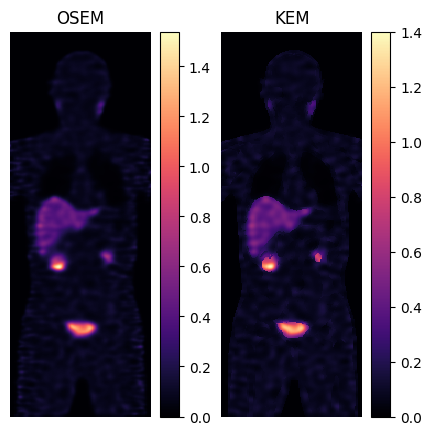

In [10]:
plt.subplots(1,2,figsize=(5,5))
plt.subplot(121)
plt.pcolormesh(reconstructed_object[0].cpu()[:,64].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('OSEM')
plt.subplot(122)
plt.pcolormesh(recon_kem.cpu()[0][:,64].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('KEM')
plt.show()